In [11]:
import pandas as pd
try:
  import xml.etree.cElementTree as et
except ImportError:
  import xml.etree.ElementTree as et
import numpy as np   
import math
from sklearn.model_selection import KFold
import scipy
import os

K_DEPTH_VIEW = 30
K_DEPTH_SAT = 10
MAX_REL = 5
MED_REL = 3

In [12]:
'''
Parse THUIR1
'''
DATA_DIR = "THUIR1/search_sessions/"
SCORE_FILE="THUIR1/metrics.txt"
REL_FILE = "THUIR1/relevance.txt"

In [13]:
parsed_log = []
ss = [] # score list
rels = [] # relevance list

with open (SCORE_FILE, 'r+', encoding = 'utf-8') as f:
    ss = [i[:-1].split('\t') for i in f.readlines()]
    
with open (REL_FILE, 'r+', encoding = 'utf-8') as f:
    rels = [i[:-1].split('\t') for i in f.readlines()]

for rec in ss:
    sat = -1
    session_id = rec[0]
    serp_id = session_id.split('_')[1]
    cl = [] # click list
    
    # Parse log
    #print(session_id)
    try:
        with open (DATA_DIR+session_id, 'r+', encoding = 'utf-8') as f:
            for i in f.readlines():
                l = i[:-1].split('\t')
                if l[2] == 'ACTION=SATISFY':
                    # Extract satisfaction score
                    sat = float(l[4][-1])
                if l[2] == 'ACTION=CLICK':
                    # Extract distinct click record
                    c = int(l[5][-1])
                    if c not in cl:
                        cl.append(c)             
    except:
        continue
    nc = len(cl)
    if nc:
        dc = max(cl) + 1
    else:
        dc = 0
    query_result = []
    for rel in rels:
        if rel[0] == serp_id:
            for rank in range(0,10):
                query_result.append({'doc_id':serp_id + str(rank), 'doc_rank': str(rank), 'doc_rel': str(rel[rank+1])})
    
    
    parsed_log.append({'id':session_id, 'result':query_result, 'sat': str(sat), 'nc': str(nc), 'dc': str(dc)})       


print(len(parsed_log))
print(parsed_log[1000])

2391
{'id': '29_52', 'result': [{'doc_id': '520', 'doc_rank': '0', 'doc_rel': '1.7'}, {'doc_id': '521', 'doc_rank': '1', 'doc_rel': '1.7'}, {'doc_id': '522', 'doc_rank': '2', 'doc_rel': '2.0'}, {'doc_id': '523', 'doc_rank': '3', 'doc_rel': '2.0'}, {'doc_id': '524', 'doc_rank': '4', 'doc_rel': '2.0'}, {'doc_id': '525', 'doc_rank': '5', 'doc_rel': '2.0'}, {'doc_id': '526', 'doc_rank': '6', 'doc_rel': '2.0'}, {'doc_id': '527', 'doc_rank': '7', 'doc_rel': '2.0'}, {'doc_id': '528', 'doc_rank': '8', 'doc_rel': '2.0'}, {'doc_id': '529', 'doc_rank': '9', 'doc_rel': '3.7'}], 'sat': '2.0', 'nc': '2', 'dc': '4'}


In [17]:
def s_insq(x):
    res = 0
    for i in range(1, x+1):
        res += 1/i**2
    return math.pi**2 / 6 - res

def gain(rel):
    return rel

def gain_err(rel):
    return (2**rel - 1)/2**MAX_REL

# The probability users view the document at rank n
# Supposed they always view the first document
def decay_dcg (b, n):
    return 1.0/(1+ math.log(n,b))

def v_rbp(p, n):
    return p**(n-1)

def v_insq(t, n, last_prob):
    if n == 1:
        return 1
    else:
        return last_prob * ((n + 2*t - 2)/(n + 2*t -1))**2
    
def v_inst(t, n, cr, last_prob):
    if last_prob <= 0:
        return 0
    
    if n == 1:
        return 1
    else:
        tn = t - cr
        v = last_prob * ((n + t + tn - 2)/(n + t + tn - 1))**2
        if v > 0:
            return v
        else:
            return 0
        
def w_rbp(p, n):
    return (1-p) * (p**(n-1))

def w_err(rank, last_prob):
    return (1.0/rank) * last_prob

def w_p():
    return 1/K_DEPTH_SAT 

def w_insq(t, n):
    return (1/s_insq(2*t-1)) * (1/(n + 2*t - 1)**2)

def w_inst(t, n, cr):
    w = (1/(s_insq(2*t-1))*(1/(n + 2*t - cr -1)**2)
    if w > 0:
         return w
    else:
        return 0
    
    

In [18]:
DCG_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
RBP_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
INSQ_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
INST_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
METRIC = {'DCG':'dcg', 'RBP':'rbp', 'ERR':'err', 'P':'p', 'INSQ':'insq', 'INST':'inst'}

'''
RQ1 - How to issue a new framework incorporating the anchoring effect into IR metrics
'''

def default_run(pm, result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    res = 0
    last_prob = 1.0 # For ERR
    cr = 0 # For INST
    for doc in result_list:
        if int(doc['doc_rank'])< K_DEPTH_SAT:
            cur_rel = float(doc['doc_rel'])
            cur_rank = int(doc['doc_rank'])+1
            if metric == 'DCG':
                cur_gain = gain(cur_rel)*decay_dcg(pm, cur_rank)
            elif metric == 'RBP':
                cur_gain = gain(cur_rel)*w_rbp(pm, cur_rank)
            elif metric == 'ERR':
                cur_gain = gain_err(cur_rel)*w_err(cur_rank, last_prob)
                last_prob *= 1- cur_gain
            elif metric == 'P':
                cur_gain = gain(cur_rel)*w_p()
            elif metric == 'INSQ':
                cur_gain = gain(cur_rel) * w_insq(pm, cur_rank)
            elif metric == 'INST':
                cur_gain = gain(cur_rel) * w_inst(pm, cur_rank, cr)
                cr += cur_rel/MAX_REL
            res += cur_gain
    return res

def AEM_run(pm, l, k,result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    res = 0.0
    last_rel = -1.0
    # For ERR
    last_prob = 1.0
    # For INST
    cr = 0
    for doc in result_list:
        cur_rank = int(doc['doc_rank']) + 1
        if cur_rank <= K_DEPTH_SAT:
            # First doc
            if cur_rank == 1:
                cur_rel = float(doc['doc_rel'])
            else:
                x = (last_rel - MED_REL)/(MAX_REL-MED_REL)
                a = l / (k + math.exp(-(1/k)*(x)))
                if a > l:
                    a = l
                cur_rel = a*last_rel + (1-a)*float(doc['doc_rel'])
                
            # We assume that users assess documents objectively, 
            # but their gain from the current document is affected by the quality of the last document
            if metric == 'DCG':
                cur_gain = gain(cur_rel)*decay_dcg(pm, cur_rank)
            elif metric == 'RBP':
                cur_gain = gain(cur_rel)*w_rbp(pm, cur_rank)
            elif metric == 'ERR':
                cur_gain = gain_err(cur_rel)*w_err(cur_rank, last_prob)
                last_prob *= (1- cur_gain)
            elif metric == 'P':
                cur_gain =  gain(cur_rel)*w_p()
            elif metric == 'INSQ':
                cur_gain = gain(cur_rel) * w_insq(pm, cur_rank)
            elif metric == 'INST':
                cur_gain = gain(cur_rel)*w_inst(pm, cur_rank, cr)
                cr += cur_rel/MAX_REL
        else:
            break
        res += cur_gain
        # Real Quality
        last_rel = float(doc['doc_rel'])
    #print(res)
    return res
        
def compute_TSE(train_set, metric, pm):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    tse = 0
    last_prob = 1 # For INSQ & INST
    cr = 0 # For INST
    for q in train_set:
        dc = int(q['dc'])
        nc = int(q['nc'])
        for rank in range(1, K_DEPTH_VIEW+1):
            if metric == 'DCG':
                p_dr_hat = decay_dcg(pm, rank)
            elif metric == 'RBP':
                p_dr_hat = v_rbp(pm, rank)
            elif metric == 'INSQ':
                p_dr_hat = v_insq(pm, rank, last_prob)
                last_prob *= p_dr_hat
            elif metric == 'INST':
                if rank <= K_DEPTH_SAT:
                    cur_rel = float(q['result'][rank-1]['doc_rel'])
                else:
                    cur_rel = 0
                p_dr_hat = v_inst(pm, rank, cr, last_prob)
                last_prob *= p_dr_hat
                cr += cur_rel/MAX_REL
                
            if rank <= dc:
                p_dr = 1
            else:
                n = rank - dc
                #k = 5.1 + dc* 0.29 - nc*0.14 # Wickasono(2021) Model2
                k = 3.48 - dc* 0.46 + nc * 0.2  # Wickasono(2020) for THUIR1
                if(k < 0):
                    p_dr = 0
                else:
                    p_dr = math.exp((-1.0*n)/k)
            tse += (p_dr_hat - p_dr)**2
            
    return tse
        
'''
Grid Search for DCG
'''
def train_dcg_baseline(train_set, mode):
    if mode not in DCG_MODE:
        raise Exception('No such mode: %s'%(mode))
    
    dcg_b={}   
    for b in np.arange(1.1, 5.01, 0.1):
        b = round(b, 2)
        if mode == 'BEHAVIOUR':
            dcg_b[b] = compute_TSE(train_set, 'DCG', b)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(b, q['result'],  'DCG') for q in train_set]
            dcg_b[b] = scipy.stats.spearmanr(X, Y).correlation
    
    if mode == 'BEHAVIOUR':
        b_st = min(dcg_b, key = dcg_b.get)
    elif mode == 'SATISFACTION':
        b_st = max(dcg_b, key = dcg_b.get)
        
    return b_st


'''
Grid Search for RBP
'''
def train_rbp_baseline(train_set, mode):
    if mode not in RBP_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    rbp_p = {}
    for p in np.arange(0, 1.01, 0.05):
        p = round(p, 2)
        if mode == 'BEHAVIOUR':
            rbp_p[p] = compute_TSE(train_set, 'RBP', p)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(p, q['result'], 'RBP') for q in train_set]
            rbp_p[p] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        p_st = min(rbp_p, key = rbp_p.get)
    elif mode == 'SATISFACTION':
        p_st = max(rbp_p, key = rbp_p.get)
        
    return p_st
        
'''
Grid Search for INSQ
'''
def train_insq_baseline(train_set, mode):
    if mode not in INSQ_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    insq_t = {}
    for t in range(1, 25):
        if mode == 'BEHAVIOUR':
            insq_t[t] = compute_TSE(train_set, 'INSQ', t)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(t, q['result'], 'INSQ') for q in train_set]
            insq_t[t] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        t_st = min(insq_t, key = insq_t.get)
    elif mode == 'SATISFACTION':
        t_st = max(insq_t, key = insq_t.get)
        
    return t_st

        
'''
Grid Search for INST
'''
def train_inst_baseline(train_set, mode):
    if mode not in INST_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    inst_t = {}
    for t in range(1, 25):
        if mode == 'BEHAVIOUR':
            insq_t[t] = compute_TSE(train_set, 'INST', t)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(t, q['result'], 'INST') for q in train_set]
            insq_t[t] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        t_st = min(inst_t, key = inst_t.get)
    elif mode == 'SATISFACTION':
        t_st = max(inst_t, key = inst_t.get)
        
    return t_st

'''
Grid Search for Callibrating lambda and kappa for AEMs
'''

def train_AEM(pm, train_set, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    map_aem = {}
    Y = [float(q['sat']) for q in train_set]
    for l in np.arange(0, 1.01, 0.1):
        l = round(l, 3)
        for k in np.arange(0, 0.501, 0.05):
            k = round(k, 4)
            if metric == 'DCG':
                X = [AEM_run(pm, l, k, q['result'], 'DCG') for q in train_set]
            elif metric == 'RBP':
                X = [AEM_run(pm, l, k, q['result'], 'RBP') for q in train_set]
            elif metric == 'ERR':
                X =  [AEM_run(pm, l, k, q['result'], 'ERR') for q in train_set]
            elif metric == 'P':
                X =  [AEM_run(pm, l, k, q['result'], 'P') for q in train_set]
            elif metric == 'INSQ':
                X =  [AEM_run(pm, l, k, q['result'], 'INSQ') for q in train_set]
            elif metric == 'INST':
                X =  [AEM_run(pm, l, k, q['result'], 'INST') for q in train_set]
            if not(l in map_aem):
                map_aem[l] = {}
            map_aem[l][k] = scipy.stats.spearmanr(X, Y).correlation
    # Find best parameter   
    r = -1
    l_st = -1
    k_st = -1
    for l in map_aem:
        for k in map_aem[l]:
            if map_aem[l][k] > r:
                r = map_aem[l][k]
                l_st = l
                k_st = k
    return (l_st, k_st)


In [19]:
rl_dcg_b = []
rl_dcg_s = []
rl_dcg_AEM = []

rl_rbp_b = []
rl_rbp_s = []
rl_rbp_AEM = []

rl_err = []
rl_err_AEM = []

rl_p = []
rl_p_AEM = []

rl_insq_b = []
rl_insq_s = []
rl_insq_AEM = []

l1s = []
k1s = []
bbs = []
bss = []

l2s = []
k2s = []
pbs = []
pss = []

l3s = []
k3s = []

l4s = []
k4s = []

l5s = []
k5s = []
t1bs = []
t1ss = []


tt = 0

for i in range(0, 10):
    kf = KFold(n_splits=5,shuffle=True)
    for train_index , test_index in kf.split(parsed_log): 
        tt+=1
        print('training: %s'%(tt))
        train_set = [parsed_log[i] for i in train_index]
        test_set = [parsed_log[i] for i in test_index]

        b_b = train_dcg_baseline(train_set, 'BEHAVIOUR')
        b_s = train_dcg_baseline(train_set, 'SATISFACTION')
        l_1, k_1 = train_AEM(b_b, train_set, 'DCG')
        l1s.append(l_1)
        k1s.append(k_1)
        bbs.append(b_b)
        bss.append(b_s)
        
        p_b = train_rbp_baseline(train_set, 'BEHAVIOUR')
        p_s = train_rbp_baseline(train_set, 'SATISFACTION')
        l_2, k_2 = train_AEM(p_b, train_set, 'RBP')
        l2s.append(l_2)
        k2s.append(k_2)
        pbs.append(p_b)
        pss.append(p_s)
        
        l_3, k_3 = train_AEM(-1, train_set, 'ERR')
        l3s.append(l_3)
        k3s.append(k_3)
        
        l_4, k_4 = train_AEM(-1, train_set, 'P')
        l4s.append(l_4)
        k4s.append(k_4)
        
        t1_b = train_insq_baseline(train_set, 'BEHAVIOUR')
        t1_s = train_insq_baseline(train_set, 'SATISFACTION')
        l_5, k_5 = train_AEM(t1_b, train_set, 'INSQ')
        l5s.append(l_5)
        k5s.append(k_5)
        t1bs.append(t1_b)
        t1ss.append(t1_s)
        
        X_dcg_b = [default_run(b_b, q['result'], 'DCG') for q in test_set]
        X_dcg_s = [default_run(b_s, q['result'], 'DCG') for q in test_set]
        X_dcg_AEM = [AEM_run(b_b, l_1 , k_1, q['result'], 'DCG') for q in test_set]
        
        X_rbp_b = [default_run(p_b, q['result'], 'RBP') for q in test_set]
        X_rbp_s = [default_run(p_s, q['result'], 'RBP') for q in test_set]
        X_rbp_AEM = [AEM_run(p_b, l_2 , k_2, q['result'], 'RBP') for q in test_set]
        
        X_err = [default_run(-1, q['result'], 'ERR')  for q in test_set]
        X_err_AEM = [AEM_run(-1, l_3 , k_3, q['result'], 'ERR') for q in test_set]
        
        X_p = [default_run(-1, q['result'], 'P')  for q in test_set]
        X_p_AEM = [AEM_run(-1, l_4 , k_4, q['result'], 'P') for q in test_set]
        
        X_insq_b = [default_run(t1_b, q['result'], 'INSQ') for q in test_set]
        X_insq_s = [default_run(t1_s, q['result'], 'INSQ') for q in test_set]
        X_insq_AEM = [AEM_run(t1_b, l_5 , k_5, q['result'], 'INSQ') for q in test_set]
        
        Y = [float(q['sat']) for q in test_set]
        
        rl_dcg_b.append(scipy.stats.spearmanr(X_dcg_b, Y).correlation)
        rl_dcg_s.append(scipy.stats.spearmanr(X_dcg_s, Y).correlation)
        rl_dcg_AEM.append(scipy.stats.spearmanr(X_dcg_AEM, Y).correlation)
        print("DCG b_b=%3f b_s = %3f b-rel=%4f s-rel=%4f"%(b_b, b_s, scipy.stats.spearmanr(X_dcg_b, Y).correlation, scipy.stats.spearmanr(X_dcg_s, Y).correlation))
        print("AEM-DCG lambda=%3f, kappa=%3f rel=%4f"%(l_1, k_1, scipy.stats.spearmanr(X_dcg_AEM, Y).correlation))
    
        rl_rbp_b.append(scipy.stats.spearmanr(X_rbp_b, Y).correlation)
        rl_rbp_s.append(scipy.stats.spearmanr(X_rbp_s, Y).correlation)
        rl_rbp_AEM.append(scipy.stats.spearmanr(X_rbp_AEM, Y).correlation)
        print("RBP p_b=%3f, p_s=%3f b-rel=%4f s-rel=%4f"%(p_b, p_s, scipy.stats.spearmanr(X_rbp_b, Y).correlation, scipy.stats.spearmanr(X_rbp_s, Y).correlation))
        print("AEM-RBP lambda=%3f, kappa=%3f rel=%4f"%(l_2, k_2, scipy.stats.spearmanr(X_rbp_AEM, Y).correlation))
        
        rl_err.append(scipy.stats.spearmanr(X_err, Y).correlation)
        rl_err_AEM.append(scipy.stats.spearmanr(X_err_AEM, Y).correlation)
        print("ERR rel=%4f"%(scipy.stats.spearmanr(X_err, Y).correlation))
        print("AEM-ERR lambda=%3f, kappa=%3f rel=%4f"%(l_3, k_3, scipy.stats.spearmanr(X_err_AEM, Y).correlation))
        
        rl_p.append(scipy.stats.spearmanr(X_p, Y).correlation)
        rl_p_AEM.append(scipy.stats.spearmanr(X_p_AEM, Y).correlation)
        print("Prec rel=%4f"%(scipy.stats.spearmanr(X_p, Y).correlation))
        print("AEM-Prec lambda=%3f, kappa=%3f rel=%4f"%(l_4, k_4, scipy.stats.spearmanr(X_p_AEM, Y).correlation))
        
        rl_insq_b.append(scipy.stats.spearmanr(X_insq_b, Y).correlation)
        rl_insq_s.append(scipy.stats.spearmanr(X_insq_s, Y).correlation)
        rl_insq_AEM.append(scipy.stats.spearmanr(X_insq_AEM, Y).correlation)
        print("INSQ t_b=%3f t_s = %3f b-rel=%4f s-rel=%4f"%(t1_b, t1_s, scipy.stats.spearmanr(X_insq_b, Y).correlation, scipy.stats.spearmanr(X_insq_s, Y).correlation))
        print("AEM-INSQ lambda=%3f, kappa=%3f rel=%4f"%(l_5, k_5, scipy.stats.spearmanr(X_insq_AEM, Y).correlation))
    

training: 1


/Users/kohira/anaconda2/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/Users/kohira/anaconda2/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


DCG b_b=1.900000 b_s = 1.500000 b-rel=0.318041 s-rel=0.317509
AEM-DCG lambda=1.000000, kappa=0.200000 rel=0.354815
RBP p_b=0.850000, p_s=0.750000 b-rel=0.309270 s-rel=0.318791
AEM-RBP lambda=1.000000, kappa=0.300000 rel=0.353408
ERR rel=0.331686
AEM-ERR lambda=1.000000, kappa=0.100000 rel=0.337816
Prec rel=0.254541
AEM-Prec lambda=1.000000, kappa=0.300000 rel=0.327996
INSQ t_b=2.000000 t_s = 2.000000 b-rel=0.314076 s-rel=0.314076
AEM-INSQ lambda=1.000000, kappa=0.150000 rel=0.339006
training: 2
DCG b_b=1.900000 b_s = 1.600000 b-rel=0.389953 s-rel=0.395690
AEM-DCG lambda=1.000000, kappa=0.200000 rel=0.407163
RBP p_b=0.850000, p_s=0.750000 b-rel=0.376623 s-rel=0.393800
AEM-RBP lambda=1.000000, kappa=0.500000 rel=0.399918
ERR rel=0.394256
AEM-ERR lambda=1.000000, kappa=0.100000 rel=0.389303
Prec rel=0.297848
AEM-Prec lambda=1.000000, kappa=0.350000 rel=0.352975
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.382550 s-rel=0.395709
AEM-INSQ lambda=1.000000, kappa=0.500000 rel=0.402034
training: 3


DCG b_b=1.900000 b_s = 1.600000 b-rel=0.330690 s-rel=0.334414
AEM-DCG lambda=1.000000, kappa=0.200000 rel=0.365248
RBP p_b=0.850000, p_s=0.750000 b-rel=0.321862 s-rel=0.338842
AEM-RBP lambda=1.000000, kappa=0.500000 rel=0.363992
ERR rel=0.353188
AEM-ERR lambda=0.000000, kappa=0.050000 rel=0.353188
Prec rel=0.252697
AEM-Prec lambda=1.000000, kappa=0.300000 rel=0.327687
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.325169 s-rel=0.335311
AEM-INSQ lambda=1.000000, kappa=0.500000 rel=0.362638
training: 19
DCG b_b=1.900000 b_s = 1.600000 b-rel=0.309276 s-rel=0.312597
AEM-DCG lambda=1.000000, kappa=0.200000 rel=0.316625
RBP p_b=0.850000, p_s=0.750000 b-rel=0.302103 s-rel=0.303033
AEM-RBP lambda=1.000000, kappa=0.300000 rel=0.311670
ERR rel=0.331561
AEM-ERR lambda=1.000000, kappa=0.100000 rel=0.312522
Prec rel=0.273026
AEM-Prec lambda=1.000000, kappa=0.300000 rel=0.287399
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.303622 s-rel=0.304992
AEM-INSQ lambda=1.000000, kappa=0.100000 rel=0.308026
training: 2

DCG b_b=1.900000 b_s = 1.400000 b-rel=0.359094 s-rel=0.347605
AEM-DCG lambda=1.000000, kappa=0.200000 rel=0.373587
RBP p_b=0.850000, p_s=0.750000 b-rel=0.357995 s-rel=0.352905
AEM-RBP lambda=1.000000, kappa=0.500000 rel=0.372607
ERR rel=0.358049
AEM-ERR lambda=1.000000, kappa=0.100000 rel=0.351296
Prec rel=0.329247
AEM-Prec lambda=1.000000, kappa=0.300000 rel=0.371943
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.357595 s-rel=0.349111
AEM-INSQ lambda=1.000000, kappa=0.500000 rel=0.372646
training: 36
DCG b_b=1.900000 b_s = 1.400000 b-rel=0.338071 s-rel=0.337103
AEM-DCG lambda=1.000000, kappa=0.200000 rel=0.347518
RBP p_b=0.850000, p_s=0.750000 b-rel=0.328922 s-rel=0.338909
AEM-RBP lambda=1.000000, kappa=0.300000 rel=0.347028
ERR rel=0.334903
AEM-ERR lambda=1.000000, kappa=0.150000 rel=0.328243
Prec rel=0.267545
AEM-Prec lambda=1.000000, kappa=0.300000 rel=0.312324
INSQ t_b=4.000000 t_s = 2.000000 b-rel=0.329757 s-rel=0.335821
AEM-INSQ lambda=1.000000, kappa=0.250000 rel=0.345961
training: 3

In [20]:
rl_dcg_b = pd.Series(rl_dcg_b)
rl_dcg_s = pd.Series(rl_dcg_s)
rl_dcg_AEM = pd.Series(rl_dcg_AEM)

rl_rbp_b = pd.Series(rl_rbp_b)
rl_rbp_s = pd.Series(rl_rbp_s)
rl_rbp_AEM = pd.Series(rl_rbp_AEM)

rl_err = pd.Series(rl_err)
rl_err_AEM = pd.Series(rl_err_AEM)

rl_p = pd.Series(rl_p)
rl_p_AEM = pd.Series(rl_p_AEM)

rl_insq_b = pd.Series(rl_insq_b)
rl_insq_s = pd.Series(rl_insq_s)
rl_insq_AEM = pd.Series(rl_insq_AEM)

l1s = pd.Series(l1s)
k1s = pd.Series(k1s)
bbs = pd.Series(bbs)
bss =  pd.Series(bss)

l2s = pd.Series(l2s)
k2s = pd.Series(k2s)
pbs =  pd.Series(pbs)
pss =  pd.Series(pss)

l3s = pd.Series(l3s)
k3s = pd.Series(k3s)

l4s = pd.Series(l4s)
k4s = pd.Series(k4s)

l5s = pd.Series(l5s)
k5s = pd.Series(k5s)
t1bs = pd.Series(t1bs)
t1ss =  pd.Series(t1ss)

In [21]:
'''
RQ2 - The peformance of AEMs compared with SOTA metrics
'''

print('############')
print('b_b Mean: %.3f    Std:%.3f    DCG_UB Mean: %.3f    Std:%.3f      '%(bbs.mean(), bbs.std(), rl_dcg_b.mean(), rl_dcg_b.std())) 
print('############')
print('b_s Mean: %.3f    Std:%.3f    DCG_US Mean: %.3f     Std:%.3f       '%(bss.mean(), bss.std(), rl_dcg_s.mean(), rl_dcg_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_DCG Mean: %.3f     Std:%.4f'%(l1s.mean(), l1s.std(), k1s.mean(), k1s.std(), rl_dcg_AEM.mean(), rl_dcg_AEM.std()))
print('############')
stat, p = scipy.stats.ttest_ind(rl_dcg_b, rl_dcg_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_ind(rl_dcg_s, rl_dcg_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('p_b Mean: %.3f    Std:%.3f    RBP_UB Mean: %.3f     Std:%.3f    '%(pbs.mean(), pbs.std(),rl_rbp_b.mean(), rl_rbp_b.std())) 
print('############')
print('p_s Mean: %.3f    Std:%.3f    RBP_US Mean: %.3f     Std:%.3f   '%(pss.mean(), pss.std(), rl_rbp_s.mean(), rl_rbp_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_RBP Mean: %.3f     Std:%.4f'%(l2s.mean(), l2s.std(), k2s.mean(), k2s.std(), rl_rbp_AEM.mean(), rl_rbp_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_ind(rl_rbp_b, rl_rbp_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_ind(rl_rbp_s, rl_rbp_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('ERR Mean: %.3f     Std:%.3f'%(rl_err.mean(), rl_err.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_ERR Mean: %.3f     Std:%.4f'%(l3s.mean(), l3s.std(), k3s.mean(), k3s.std(), rl_err_AEM.mean(), rl_err_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_ind(rl_err, rl_err_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('Prec Mean: %.3f     Std:%.3f'%(rl_p.mean(), rl_p.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_Prec Mean: %.3f     Std:%.4f'%(l4s.mean(), l4s.std(), k4s.mean(), k4s.std(), rl_p_AEM.mean(), rl_p_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_ind(rl_p, rl_p_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))

print('############')
print('t_b Mean: %.3f    Std:%.3f    INSQ_UB Mean: %.3f     Std:%.3f    '%(t1bs.mean(), t1bs.std(),rl_insq_b.mean(), rl_insq_b.std())) 
print('############')
print('t_s Mean: %.3f    Std:%.3f    INSQ_US Mean: %.3f     Std:%.3f   '%(t1ss.mean(), t1ss.std(), rl_insq_s.mean(), rl_insq_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    AEM_INSQ Mean: %.3f     Std:%.4f'%(l5s.mean(), l5s.std(), k5s.mean(), k5s.std(), rl_insq_AEM.mean(), rl_insq_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_ind(rl_insq_b, rl_insq_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))
stat, p = scipy.stats.ttest_ind(rl_insq_s, rl_insq_AEM)
print('stat=%.3f, p=%.4f' % (stat, p))




############
b_b Mean: 1.900    Std:0.000    DCG_UB Mean: 0.335    Std:0.041      
############
b_s Mean: 1.518    Std:0.069    DCG_US Mean: 0.337     Std:0.041       
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.209    Std:0.045    AEM_DCG Mean: 0.362     Std:0.0419
############
stat=-3.153, p=0.0021
stat=-2.960, p=0.0039
############
p_b Mean: 0.850    Std:0.000    RBP_UB Mean: 0.326     Std:0.042    
############
p_s Mean: 0.750    Std:0.000    RBP_US Mean: 0.340     Std:0.042   
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.374    Std:0.108    AEM_RBP Mean: 0.360     Std:0.0425
############
stat=-3.984, p=0.0001
stat=-2.403, p=0.0181
############
ERR Mean: 0.359     Std:0.041
############
lambda Mean: 0.828    Std:0.368    kappa Mean: 0.093    Std:0.023    AEM_ERR Mean: 0.359     Std:0.0404
############
stat=0.078, p=0.9382
############
Prec Mean: 0.263     Std:0.041
############
lambda Mean: 1.000    Std:0.000    kappa Mean: 0.316    Std:0.024    A

In [1]:
'''
About Kappa
'''
import matplotlib.pyplot as plt

NameError: name 'k1s' is not defined

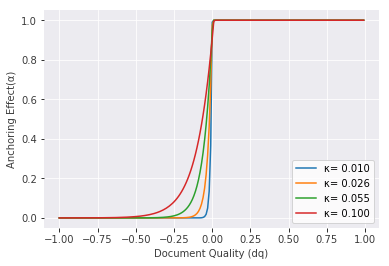

In [29]:
k_min = 0.010
k_dcg = k1s.mean()
k_rbp = k2s.mean()
k_max = 0.100

x = [i for i in np.arange(-1, 1, 0.01)]
y1 = []
y2 = []
y3 = []
y4 = []
for i in x:
    y1.append(min(1/(k_dcg + math.exp(-(1/k_dcg)*(i))), 1))
    y2.append(min(1/(k_rbp + math.exp(-(1/k_rbp)*(i))), 1))
    y3.append(min(1/(k_min + math.exp(-(1/k_min)*(i))), 1))
    y4.append(min(1/(k_max + math.exp(-(1/k_max)*(i))), 1))
    
#plt.figure(figsize=(14, 9))
plt.plot(x, y3, label = "κ= %.3f"%(k_min))
plt.plot(x, y1, label = "κ= %.3f"%(k_dcg))
plt.plot(x, y2, label = "κ= %.3f"%(k_rbp))
plt.plot(x, y4, label = "κ= %.3f"%(k_max))

ax = plt.gca()

ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框

plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")

plt.xlabel('Document Quality (dq)', color = "#3c3c3c")
plt.ylabel('Anchoring Effect(α)', color = "#3c3c3c")

plt.legend(loc='lower right')
plt.savefig('kappa-compare.png', dpi=1100, bbox_inches='tight')

plt.show()

In [48]:
'''
R with different kappa
'''
rbp_X = []
rbp_Y = []
dcg_X = []
dcg_Y = []

def search_AEM(pm, train_set, metric):
    aem = {}
    Y = [float(q['sat']) for q in train_set]
    for l in np.arange(1, 1.01, 1):
        l = round(l, 3)
        for k in np.arange(0.01, 0.101, 0.01):
            k = round(k, 4)
            if metric == 'RBP':
                X = [AEM_run(pm, l, k, q['result'], 'RBP') for q in train_set]
            elif metric == 'DCG':
                X = [AEM_run(pm, l, k, q['result'], 'DCG') for q in train_set]
            if l not in aem:
                aem[l] = {}
            aem[l][k] = scipy.stats.spearmanr(X, Y).correlation       
            
    for l in aem:
        for k in aem[l]:
            if metric == 'RBP':
                rbp_X.append(k)
                rbp_Y.append(aem[l][k])
            elif metric == 'DCG':
                dcg_X.append(k)
                dcg_Y.append(aem[l][k])                
    return
                             
search_AEM(1.9, parsed_log, 'DCG')            
search_AEM(0.55, parsed_log, 'RBP') 

In [49]:
print(dcg_X)
print(dcg_Y)
print(rbp_X)
print(rbp_Y)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
[0.35847140028638225, 0.35853324094168454, 0.35838003598191703, 0.35835535926441103, 0.3583336678757202, 0.35808146213370945, 0.3577074152478744, 0.35782954792213345, 0.358159647547637, 0.35813708585485404]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
[0.3340075871711262, 0.3340573645637966, 0.3341151309383656, 0.3336846510009796, 0.3341771083081038, 0.3343000017243634, 0.33402335839602026, 0.33385107295983824, 0.3334992328808811, 0.33346950201645825]


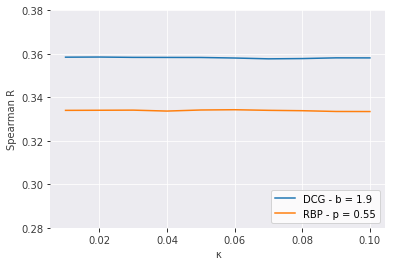

In [54]:
#plt.figure(figsize=(14, 9))
plt.plot(dcg_X, dcg_Y, label = "DCG - b = 1.9")
plt.plot(rbp_X, rbp_Y, label = "RBP - p = 0.55")
ax = plt.gca()
ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框
plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")
plt.xlabel('κ', color = "#3c3c3c")
plt.ylabel('Spearman R', color = "#3c3c3c")
plt.ylim(0.28, 0.38)
plt.legend(loc='lower right')
plt.savefig('senstivity-compare.png', dpi=1100, bbox_inches='tight')
plt.show()

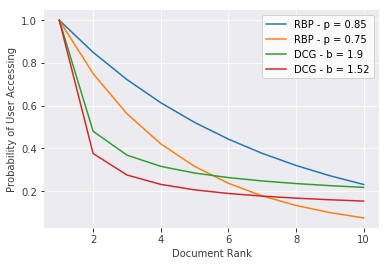

In [68]:
doc_r = []
rbp_v1 = []
rbp_v2 = []
dcg_v1 = []
dcg_v2 = []
for i in range (1, K_DEPTH_SAT+1):
    doc_r.append(i)
    rbp_v1.append(decay_rbp(0.85 ,i))
    rbp_v2.append(decay_rbp(0.75 ,i))
    dcg_v1.append(decay_dcg(1.9 ,i))
    dcg_v2.append(decay_dcg(1.52 ,i))
plt.plot(doc_r, rbp_v1, label = "RBP - p = 0.85")
plt.plot(doc_r, rbp_v2, label = "RBP - p = 0.75")
plt.plot(doc_r, dcg_v1, label = "DCG - b = 1.9")
plt.plot(doc_r, dcg_v2, label = "DCG - b = 1.52")
ax = plt.gca()
ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框
plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")
plt.xlabel('Document Rank', color = "#3c3c3c")
plt.ylabel('Probability of User Accessing', color = "#3c3c3c")
plt.legend()
plt.savefig('rbp-compare.png', dpi=1100, bbox_inches='tight')
plt.show()

In [ ]:
'''
Code for Parsing THUIR2 - Obsoleted
'''
'''
DATA_FILE = "THUIR2/search_logs.xml"
REL_FILE = "THUIR2/relevance_annotation.tsv"

myParser = et.XMLParser(encoding="utf-8")
tree = et.parse(DATA_FILE, parser=myParser)
root = tree.getroot()
''''''

In [30]:
'''
Read tsv data
'''
'''
rel_data = pd.read_csv(REL_FILE, sep = '\t', header = 0, encoding='utf-8')
'''
'''
Read XML data
'''
'''
parsed_log = []
for session in root.iter("session"): 
    session_id = session.get("num")
    query_id = ""
    for query in session.iter("interaction"):
        page_id = query.get("page_id")
        if page_id == "1":
            if query_id:
                # Add record to log
                parsed_log.append({"id":session_id+"-"+query_id, "query": query_text, "result":query_result, "sat":query_sat, "nc": nc, "dc": dc}) 
            query_id = query.get("num")
            query_text = query.find("query").text
            query_result = []
            query_sat = query.find("query_satisfaction").get("score")
            nc = 0 # number of clicks
            dc = 0 # deepest click
        current_result = query.find("results")
        current_click = query.find("clicked")
        for result in current_result:
            doc_id = result.find("id").text
            doc_rank = result.get("rank")
            rel = rel_data[rel_data['docno'] == int(doc_id)]
            if len(rel):
                doc_rel = str(rel.iloc[0, 3])
            else:
                doc_rel = ''
            query_result.append({"doc_id":doc_id, "doc_rank":doc_rank, "doc_rel": doc_rel})
        if current_click:
            for click in current_click:
                nc += 1
                dc = click.find('rank').text
    # Add record to log
    parsed_log.append({"id":session_id+"-"+query_id, "query": query_text, "result":query_result, "sat":query_sat, "nc": nc, "dc": dc}) 
    
print(parsed_log[100])
'''

{'id': '38-5', 'query': '港版 iphone6关税 ', 'result': [{'doc_id': '20392', 'doc_rank': '0', 'doc_rel': '3'}, {'doc_id': '20393', 'doc_rank': '1', 'doc_rel': '2'}, {'doc_id': '20394', 'doc_rank': '2', 'doc_rel': '3'}, {'doc_id': '20395', 'doc_rank': '3', 'doc_rel': '2'}, {'doc_id': '20396', 'doc_rank': '4', 'doc_rel': '2'}, {'doc_id': '20397', 'doc_rank': '5', 'doc_rel': ''}, {'doc_id': '20398', 'doc_rank': '6', 'doc_rel': ''}, {'doc_id': '20399', 'doc_rank': '7', 'doc_rel': ''}, {'doc_id': '20400', 'doc_rank': '8', 'doc_rel': ''}, {'doc_id': '20401', 'doc_rank': '9', 'doc_rel': ''}], 'sat': '4', 'nc': 1, 'dc': '0'}


In [31]:
'''
Dataset THUIR-2 Description
'''
'''
max_len_serp = 0
len_serp_count = {}
for q in parsed_log:
    len_serp = len(q['result'])
    if len_serp > max_len_serp:
        max_len_serp = len_serp
    if len_serp in len_serp_count:
        len_serp_count[len_serp]+=1
    else:
        len_serp_count[len_serp] = 1
print(max_len_serp)
print(len_serp_count)
'''

80
{10: 831, 20: 84, 40: 10, 30: 19, 0: 1, 80: 1, 60: 1}


In [52]:
'''
Test THUIR 1
'''
'''
ss = []
X = []
Y = []
with open (SCORE_FILE, 'r+', encoding = 'utf-8') as f:
    ss = [i[:-1].split('\t') for i in f.readlines()]
    
for rec in ss:
    sat = -1
    dcg10 = float(rec[5])
    session_id = rec[0]
    
    try:
        with open (DATA_DIR+session_id, 'r+', encoding = 'utf-8') as f:
            for i in f.readlines():
                l = i[:-1].split('\t')
                if l[2] == 'ACTION=SATISFY':
                    # Extract satisfaction score
                    sat = float(l[4][-1])
                    X.append(dcg10)
                    Y.append(sat)
    except:
        print('Error: No file found')
        continue

        
scipy.stats.spearmanr(X, Y).correlation
'''

0.3550046794140406

In [144]:
'''
def REF_run(pm, result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))    
    cur_max = []
    ref_delta = []
    # For ERR
    last_prob = 1.0
    for doc in result_list:
        if int(doc['doc_rank'])< K_DEPTH_SAT:
            if metric == 'DCG':
                cur_score = gain_dcg(float(doc['doc_rel']))*decay_dcg(pm, int(doc['doc_rank'])+1)
            elif metric == 'RBP':
                cur_score = gain_rbp(pm, float(doc['doc_rel']))*decay_rbp(pm, int(doc['doc_rank'])+1)
            elif metric == 'ERR':
                cur_score = gain_err(float(doc['doc_rel']), MAX_REL)*decay_err(int(doc['doc_rank'])+1, last_prob)
                last_prob *= (1- gain_err(float(doc['doc_rel']), MAX_REL)*decay_err(int(doc['doc_rank'])+1, last_prob))
            elif metric == 'P':
                cur_score = float(doc['doc_rel'])
            if not(len(cur_max)) or (cur_score > cur_max[-1]):
                cur_max.append(cur_score)
            else:
                cur_max.append(cur_max[-1])
                
    # Reset last_prob
    last_prob = 1.0
    for doc in result_list:
        i = int(doc['doc_rank'])
        if i and i < 9:
            if metric == 'DCG':
                cur_score = gain_dcg(float(doc['doc_rel']))*decay_dcg(pm, int(doc['doc_rank'])+1)
            elif metric == 'RBP':
                cur_score = gain_rbp(pm, float(doc['doc_rel']))*decay_rbp(pm, int(doc['doc_rank'])+1)
            elif metric == 'ERR':
                cur_score = gain_err(float(doc['doc_rel']), MAX_REL)*decay_err(int(doc['doc_rank'])+1, last_prob)
                last_prob *= (1- gain_err(float(doc['doc_rel']), MAX_REL)*decay_err(int(doc['doc_rank'])+1, last_prob))
            elif metric == 'P':
                cur_score = float(doc['doc_rel'])
            delta = cur_score - cur_max[i-1]
            if delta < 0:
                ref_delta.append(-delta)
    ref_delta = pd.Series(ref_delta)
    return ref_delta.mean()
'''

825.002

0.2222222222222222